In [3]:
!nvidia-smi

Sun Jul 10 15:37:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 510.68.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   31C    P8    22W / 320W |    652MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
# from datetime import datetime
import time, datetime
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage import zoom
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#vit
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [3]:
model =timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [4]:
train=pd.read_excel("1205_stool_train.xlsx")

In [5]:
train

,image_id,label
0,100_0042_0.jpg,0
1,100_0044_0.jpg,0
2,100_0045_0.jpg,0
3,100_0048_0.jpg,0
4,100_0049_0.jpg,0
...,...,...
36046,V1449_p2_SSL_old_0042_0.jpg,0
36047,V1449_p2_SSL_old_0043_0.jpg,0
36048,V1449_p2_SSL_old_0044_0.jpg,0
36049,V1449_p2_SSL_old_0045_0.jpg,0


In [6]:
train.label.value_counts()

0    33194
1     2857
Name: label, dtype: int64

In [7]:
valid=pd.read_excel("1205_stool_valid.xlsx")

In [8]:
valid.label.value_counts()

0    8286
1     646
Name: label, dtype: int64

In [9]:
tst_dir = glob('D:/@image_data/open_data/@sun_data/*.jpg')
tst_df = pd.DataFrame(tst_dir, columns=['image_id'])
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = tst_df['image_id'].apply(lambda x: 1 if 'stool' in x else 0)
tst_df
test=tst_df

In [10]:
test

,image_id,label
0,case100_case_M_20181106093315_0U62372110682814...,0
1,case100_case_M_20181106093315_0U62372110682814...,0
2,case100_case_M_20181106093315_0U62372110682814...,0
3,case100_case_M_20181106093315_0U62372110682814...,0
4,case100_case_M_20181106093315_0U62372110682814...,0
...,...,...
49387,stool_v1_4_sun2_00042196_1.jpg,1
49388,stool_v1_4_sun2_00042197_1.jpg,1
49389,stool_v1_4_sun2_00042199_1.jpg,1
49390,stool_v1_4_sun2_00042202_1.jpg,1


In [11]:
test.label.value_counts()

0    49133
1      259
Name: label, dtype: int64

In [18]:
CFG = {
    'fold_num': 5,
    'seed': 3000,
    'model_arch': 'efficientnet_b0',
    'img_size': 128,
    'epochs': 100,
    'train_bs': 10,
    'valid_bs': 10,
    'T_0': 10,
    'lr': 1e-5,
    'min_lr': 1e-6,
    'weight_decay':1e-5,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [20]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

In [21]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class ColonDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [22]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize, SmallestMaxSize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            #SmallestMaxSize(CFG['img_size']),
            RandomResizedCrop(CFG['img_size'], CFG['img_size'], p=0.5),
            Resize(CFG['img_size'], CFG['img_size']),   # (h, w)
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [23]:
class ColonImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        try :
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)
            #self.dropout = nn.Dropout(0.75)

        except :
            
            try : 
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, n_class)
            
            except :
                try:
                    n_features = self.model.head.fc.in_channels
                    self.model.head.fc = nn.Conv2d(n_features,n_class,kernel_size=(1, 1), stride=(1, 1))
            
                except:
                    n_features = self.model.head.in_features
                    self.model.head = nn.Linear(n_features, n_class)
            
    def forward(self, x):
        x = self.model(x)
        return x

In [24]:
def prepare_dataloader(df,valid,test, trn_idx, val_idx, trn_root='D:/temp_kyungbin/diagonis/@0718_wl_data/0906_SR/0906_SR',val_root='D:/temp_kyungbin/diagonis/@0718_wl_data/0906_SR/0906_SR',tst_root = 'D:/@image_data/open_data/@sun_data'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df
    valid_ = valid
        
    train_ds = ColonDataset(train_, trn_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = ColonDataset(valid_, val_root, transforms=get_valid_transforms(), output_label=True)
    test_ds = ColonDataset(test, tst_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="upsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=True,
        pin_memory=False,
    )
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=True,
        pin_memory=False,
    )
    return train_loader, val_loader,tst_loader

In [25]:
def prepare_dataloader(df,valid,test, trn_idx, val_idx, trn_root='D:/temp_kyungbin/diagonis/@0718_wl_data/0906_SR/0906_SR',val_root='D:/temp_kyungbin/diagonis/@0718_wl_data/0906_SR/0906_SR',tst_root = 'D:/@image_data/open_data/@sun_data'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df
    valid_ = valid
        
    train_ds = ColonDataset(train_, trn_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = ColonDataset(valid_, val_root, transforms=get_valid_transforms(), output_label=True)
    test_ds = ColonDataset(test, tst_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle= False,    
        num_workers=CFG['num_workers'],
        sampler=BalanceClassSampler(labels=train_['label'].values, mode="upsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=True,
        pin_memory=False,
    )
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=True,
        pin_memory=False,
    )
    return train_loader, val_loader,tst_loader

In [26]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
            
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    accuracy = (image_preds_all==image_targets_all).mean()
    
    print('train 2class accuracy = {:.5f}'.format(accuracy))
    print(matrix)
    
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    
    return image_preds_all, accuracy, matrix,running_loss

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    result_loss=loss_sum/sample_num
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    acc = (image_preds_all==image_targets_all).mean()
    
    print('validation 2class accuracy = {:.5f}'.format(acc))
    print(matrix)
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, matrix,result_loss



def test_one_epoch(epoch, model, loss_fn1, tst_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(tst_loader), total=len(tst_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    result_loss=loss_sum/sample_num
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    acc = (image_preds_all==image_targets_all).mean()
    
    print('test 2class accuracy = {:.5f}'.format(acc))
    print(matrix)
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, matrix,result_loss

In [27]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [28]:
os.getcwd()

'C:\\Users\\user\\bini\\stool'

In [29]:
import wandb
wandb.login()

wandb: Currently logged in as: kyungbin (endoai-colonoscopy). Use `wandb login --relogin` to force relogin


True

wandb: Currently logged in as: kyungbin. Use `wandb login --relogin` to force relogin


Training with 0 started
28840 7211


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\albumentations\augmentations\transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
epoch 0 loss: 0.2144: 100%|███████████████████████████████████████████████████████| 6639/6639 [17:46<00:00,  6.23it/s]


train 2class accuracy = 0.88658
[[28598  4596]
 [ 2934 30260]]


epoch 0 loss: 0.1162: 100%|██████████████████████████████████████████████████████████| 894/894 [02:46<00:00,  5.37it/s]


validation 2class accuracy = 0.95018
[[7877  409]
 [  36  610]]


epoch 0 loss: 0.5195: 100%|████████████████████████████████████████████████████████| 4940/4940 [19:55<00:00,  4.13it/s]

test 2class accuracy = 0.71451
[[35057 14076]
 [   25   234]]


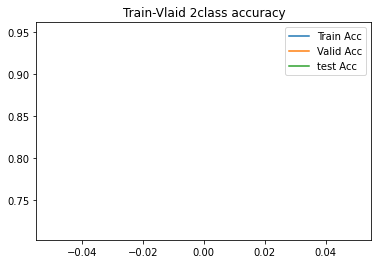

epoch 1 loss: 0.1977: 100%|████████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.07it/s]


train 2class accuracy = 0.92990
[[30463  2731]
 [ 1923 31271]]


epoch 1 loss: 0.0784: 100%|██████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.61it/s]


validation 2class accuracy = 0.96563
[[8003  283]
 [  24  622]]


epoch 1 loss: 0.3818: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:40<00:00, 22.37it/s]


test 2class accuracy = 0.80851
[[39695  9438]
 [   20   239]]


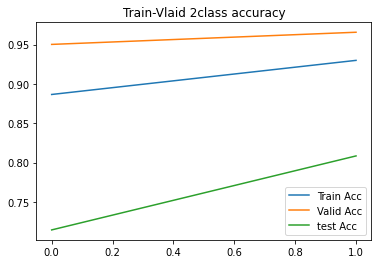

epoch 2 loss: 0.1296: 100%|████████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 11.98it/s]


train 2class accuracy = 0.94490
[[30969  2225]
 [ 1433 31761]]


epoch 2 loss: 0.0597: 100%|██████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.62it/s]


validation 2class accuracy = 0.97962
[[8143  143]
 [  39  607]]


epoch 2 loss: 0.2424: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.32it/s]


test 2class accuracy = 0.87779
[[43145  5988]
 [   48   211]]


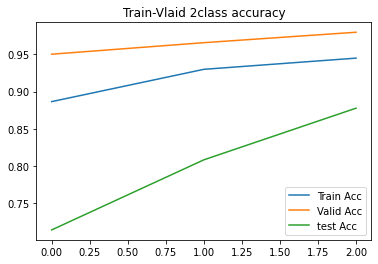

epoch 3 loss: 0.1321: 100%|████████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.03it/s]


train 2class accuracy = 0.95281
[[31303  1891]
 [ 1242 31952]]


epoch 3 loss: 0.0443: 100%|██████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.20it/s]


validation 2class accuracy = 0.98287
[[8154  132]
 [  21  625]]


epoch 3 loss: 0.1663: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.19it/s]


test 2class accuracy = 0.92590
[[45537  3596]
 [   64   195]]


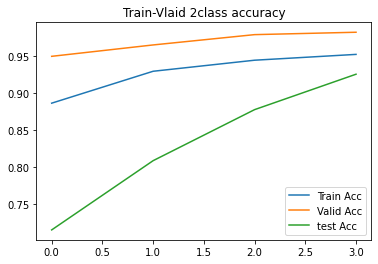

epoch 4 loss: 0.1147: 100%|████████████████████████████████████████████████████████| 6639/6639 [09:09<00:00, 12.07it/s]


train 2class accuracy = 0.95897
[[31516  1678]
 [ 1046 32148]]


epoch 4 loss: 0.0519: 100%|██████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.50it/s]


validation 2class accuracy = 0.97929
[[8116  170]
 [  15  631]]


epoch 4 loss: 0.2623: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.32it/s]


test 2class accuracy = 0.87854
[[43154  5979]
 [   20   239]]


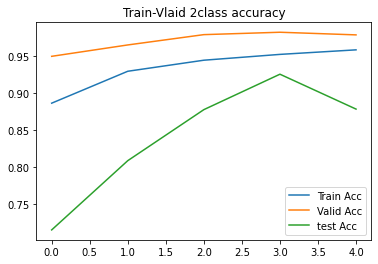

epoch 5 loss: 0.1087: 100%|████████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.07it/s]


train 2class accuracy = 0.96219
[[31668  1526]
 [  984 32210]]


epoch 5 loss: 0.0899: 100%|██████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.87it/s]


validation 2class accuracy = 0.98119
[[8155  131]
 [  37  609]]


epoch 5 loss: 0.3077: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.00it/s]


test 2class accuracy = 0.85552
[[42040  7093]
 [   43   216]]


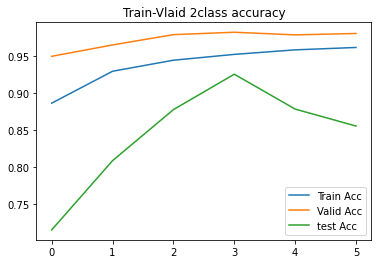

epoch 6 loss: 0.0904: 100%|████████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.29it/s]


train 2class accuracy = 0.96480
[[31778  1416]
 [  921 32273]]


epoch 6 loss: 0.0317: 100%|██████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.40it/s]


validation 2class accuracy = 0.98780
[[8215   71]
 [  38  608]]


epoch 6 loss: 0.1024: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.82it/s]


test 2class accuracy = 0.95981
[[47200  1933]
 [   52   207]]


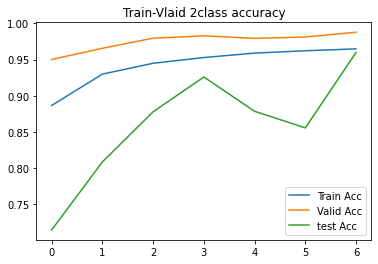

epoch 7 loss: 0.0986: 100%|████████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.31it/s]


train 2class accuracy = 0.96825
[[31906  1288]
 [  820 32374]]


epoch 7 loss: 0.0307: 100%|██████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.94it/s]


validation 2class accuracy = 0.98735
[[8206   80]
 [  33  613]]


epoch 7 loss: 0.1389: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 21.97it/s]


test 2class accuracy = 0.94149
[[46299  2834]
 [   56   203]]


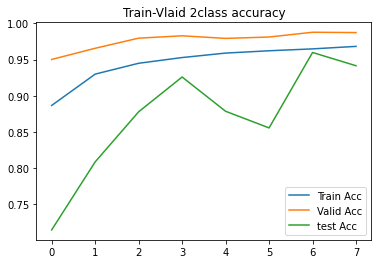

epoch 8 loss: 0.0743: 100%|████████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.97045
[[32023  1171]
 [  791 32403]]


epoch 8 loss: 0.0343: 100%|██████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.00it/s]


validation 2class accuracy = 0.98589
[[8190   96]
 [  30  616]]


epoch 8 loss: 0.2679: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.94it/s]


test 2class accuracy = 0.92681
[[45558  3575]
 [   40   219]]


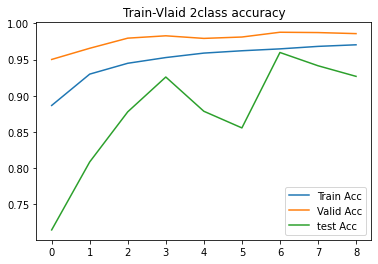

epoch 9 loss: 0.0793: 100%|████████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.97073
[[32015  1179]
 [  764 32430]]


epoch 9 loss: 0.0305: 100%|██████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.85it/s]


validation 2class accuracy = 0.98925
[[8225   61]
 [  35  611]]


epoch 9 loss: 0.0919: 100%|████████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 21.98it/s]


test 2class accuracy = 0.96194
[[47296  1837]
 [   43   216]]


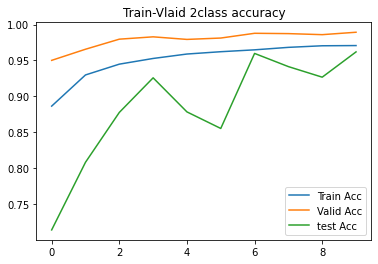

epoch 10 loss: 0.0870: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.97280
[[32081  1113]
 [  693 32501]]


epoch 10 loss: 0.0769: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.57it/s]


validation 2class accuracy = 0.98992
[[8243   43]
 [  47  599]]


epoch 10 loss: 0.1409: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 21.99it/s]


test 2class accuracy = 0.96418
[[47421  1712]
 [   57   202]]


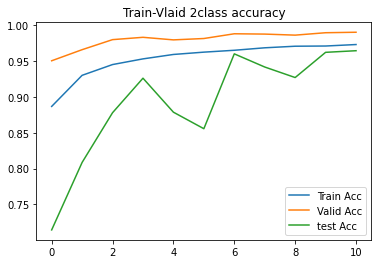

epoch 11 loss: 0.0707: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.97487
[[32174  1020]
 [  648 32546]]


epoch 11 loss: 0.0274: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.86it/s]


validation 2class accuracy = 0.98847
[[8230   56]
 [  47  599]]


epoch 11 loss: 0.1496: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.05it/s]


test 2class accuracy = 0.94469
[[46455  2678]
 [   54   205]]


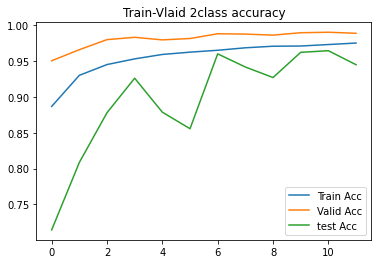

epoch 12 loss: 0.0936: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:03<00:00, 12.21it/s]


train 2class accuracy = 0.97555
[[32216   978]
 [  645 32549]]


epoch 12 loss: 0.2011: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.21it/s]


validation 2class accuracy = 0.98679
[[8201   85]
 [  33  613]]


epoch 12 loss: 1.9112: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:51<00:00, 21.36it/s]


test 2class accuracy = 0.89241
[[43844  5289]
 [   25   234]]


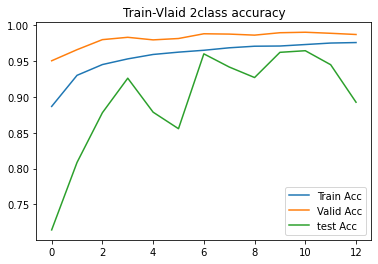

epoch 13 loss: 0.0686: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:15<00:00, 11.96it/s]


train 2class accuracy = 0.97591
[[32217   977]
 [  622 32572]]


epoch 13 loss: 0.0775: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.11it/s]


validation 2class accuracy = 0.98914
[[8226   60]
 [  37  609]]


epoch 13 loss: 0.5464: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.46it/s]


test 2class accuracy = 0.95645
[[47026  2107]
 [   44   215]]


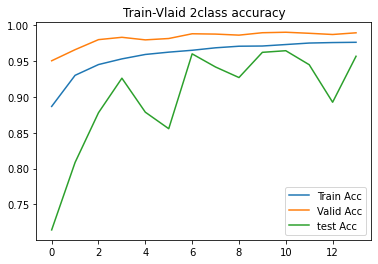

epoch 14 loss: 0.0543: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:16<00:00, 11.93it/s]


train 2class accuracy = 0.97658
[[32278   916]
 [  639 32555]]


epoch 14 loss: 0.0465: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.05it/s]


validation 2class accuracy = 0.99116
[[8239   47]
 [  32  614]]


epoch 14 loss: 0.2805: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.51it/s]


test 2class accuracy = 0.96866
[[47628  1505]
 [   43   216]]


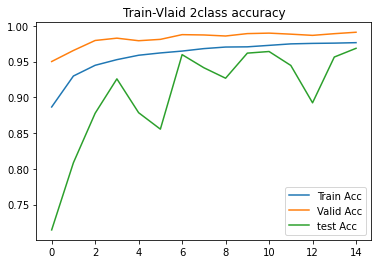

epoch 15 loss: 0.0556: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:15<00:00, 11.95it/s]


train 2class accuracy = 0.97732
[[32303   891]
 [  615 32579]]


epoch 15 loss: 0.0462: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.21it/s]


validation 2class accuracy = 0.98880
[[8220   66]
 [  34  612]]


epoch 15 loss: 0.2090: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.40it/s]


test 2class accuracy = 0.95404
[[46892  2241]
 [   29   230]]


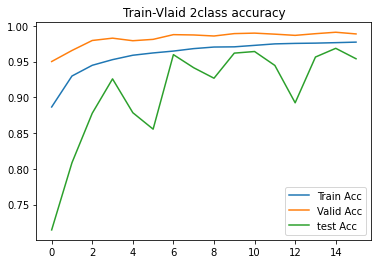

epoch 16 loss: 0.0518: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:15<00:00, 11.95it/s]


train 2class accuracy = 0.97876
[[32359   835]
 [  575 32619]]


epoch 16 loss: 0.3265: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.36it/s]


validation 2class accuracy = 0.99104
[[8238   48]
 [  32  614]]


epoch 16 loss: 0.1090: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.77it/s]


test 2class accuracy = 0.96793
[[47574  1559]
 [   25   234]]


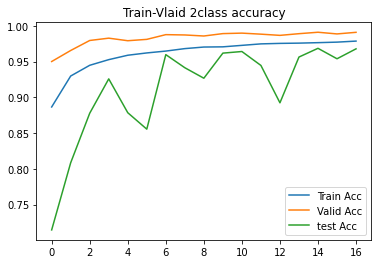

epoch 17 loss: 0.0447: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:01<00:00, 12.25it/s]


train 2class accuracy = 0.97989
[[32376   818]
 [  517 32677]]


epoch 17 loss: 0.0708: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.83it/s]


validation 2class accuracy = 0.98880
[[8243   43]
 [  57  589]]


epoch 17 loss: 0.1563: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.91it/s]


test 2class accuracy = 0.96714
[[47548  1585]
 [   38   221]]


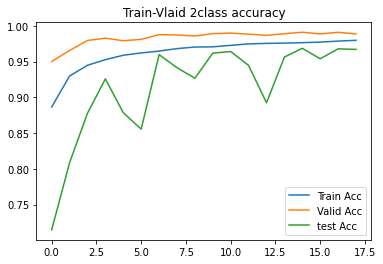

epoch 18 loss: 0.0637: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.28it/s]


train 2class accuracy = 0.97985
[[32385   809]
 [  529 32665]]


epoch 18 loss: 0.0255: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.58it/s]


validation 2class accuracy = 0.99037
[[8247   39]
 [  47  599]]


epoch 18 loss: 0.1413: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.83it/s]


test 2class accuracy = 0.97943
[[48139   994]
 [   22   237]]


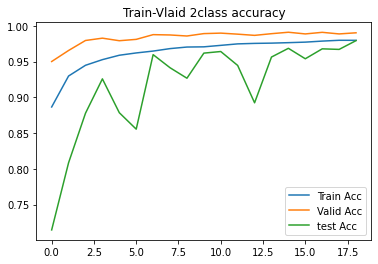

epoch 19 loss: 0.0535: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.98051
[[32409   785]
 [  509 32685]]


epoch 19 loss: 0.0724: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.98it/s]


validation 2class accuracy = 0.98936
[[8238   48]
 [  47  599]]


epoch 19 loss: 0.3136: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.95it/s]


test 2class accuracy = 0.97253
[[47801  1332]
 [   25   234]]


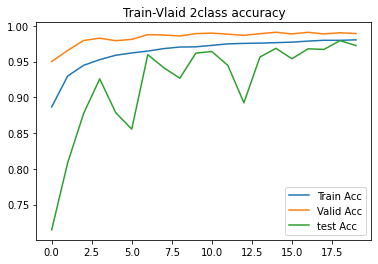

epoch 20 loss: 0.0441: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:02<00:00, 12.24it/s]


train 2class accuracy = 0.98078
[[32431   763]
 [  513 32681]]


epoch 20 loss: 0.0408: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.96it/s]


validation 2class accuracy = 0.98858
[[8237   49]
 [  53  593]]


epoch 20 loss: 0.0934: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.00it/s]


test 2class accuracy = 0.97406
[[47878  1255]
 [   26   233]]


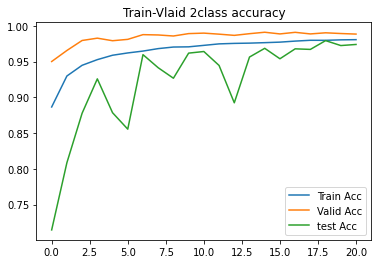

epoch 21 loss: 0.0412: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:06<00:00, 12.14it/s]


train 2class accuracy = 0.98158
[[32478   716]
 [  507 32687]]


epoch 21 loss: 0.0549: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.38it/s]


validation 2class accuracy = 0.98981
[[8236   50]
 [  41  605]]


epoch 21 loss: 0.0917: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:51<00:00, 21.36it/s]


test 2class accuracy = 0.97554
[[47964  1169]
 [   39   220]]


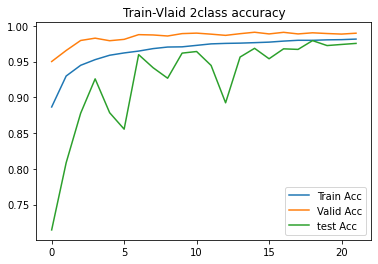

epoch 22 loss: 0.0505: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 12.00it/s]


train 2class accuracy = 0.98245
[[32484   710]
 [  455 32739]]


epoch 22 loss: 0.0535: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.25it/s]


validation 2class accuracy = 0.99082
[[8250   36]
 [  46  600]]


epoch 22 loss: 0.5263: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.43it/s]


test 2class accuracy = 0.96465
[[47432  1701]
 [   45   214]]


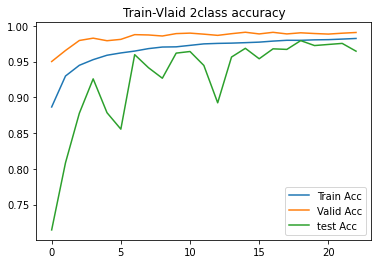

epoch 23 loss: 0.0543: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:14<00:00, 11.98it/s]


train 2class accuracy = 0.98295
[[32525   669]
 [  463 32731]]


epoch 23 loss: 0.0325: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.20it/s]


validation 2class accuracy = 0.98936
[[8256   30]
 [  65  581]]


epoch 23 loss: 0.2423: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.41it/s]


test 2class accuracy = 0.98716
[[48572   561]
 [   73   186]]


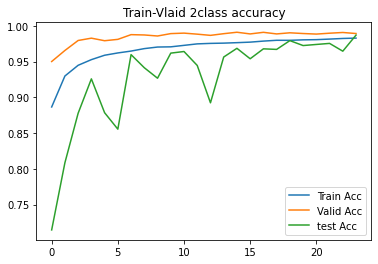

epoch 24 loss: 0.0479: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.03it/s]


train 2class accuracy = 0.98337
[[32524   670]
 [  434 32760]]


epoch 24 loss: 0.0295: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.26it/s]


validation 2class accuracy = 0.98780
[[8226   60]
 [  49  597]]


epoch 24 loss: 0.2973: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.51it/s]


test 2class accuracy = 0.93969
[[46188  2945]
 [   34   225]]


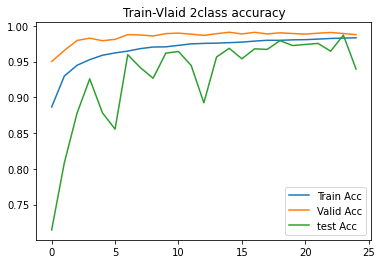

epoch 25 loss: 0.0373: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.04it/s]


train 2class accuracy = 0.98420
[[32558   636]
 [  413 32781]]


epoch 25 loss: 0.0319: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.25it/s]


validation 2class accuracy = 0.99082
[[8238   48]
 [  34  612]]


epoch 25 loss: 0.1556: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.75it/s]


test 2class accuracy = 0.97664
[[48020  1113]
 [   41   218]]


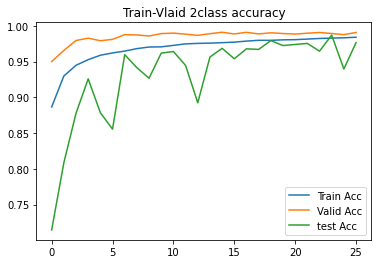

epoch 26 loss: 0.0416: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:03<00:00, 12.22it/s]


train 2class accuracy = 0.98357
[[32544   650]
 [  441 32753]]


epoch 26 loss: 0.0543: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.70it/s]


validation 2class accuracy = 0.98959
[[8255   31]
 [  62  584]]


epoch 26 loss: 0.1190: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.92it/s]


test 2class accuracy = 0.97453
[[47933  1200]
 [   58   201]]


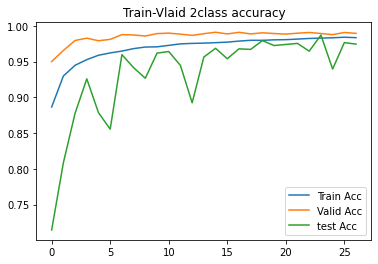

epoch 27 loss: 0.0323: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.27it/s]


train 2class accuracy = 0.98459
[[32582   612]
 [  411 32783]]


epoch 27 loss: 0.0369: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.90it/s]


validation 2class accuracy = 0.98981
[[8252   34]
 [  57  589]]


epoch 27 loss: 0.0626: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 21.98it/s]


test 2class accuracy = 0.98089
[[48222   911]
 [   33   226]]


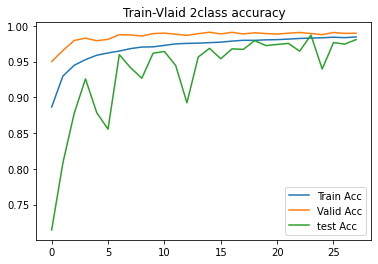

epoch 28 loss: 0.0438: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.28it/s]


train 2class accuracy = 0.98449
[[32574   620]
 [  410 32784]]


epoch 28 loss: 0.0354: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.07it/s]


validation 2class accuracy = 0.98959
[[8243   43]
 [  50  596]]


epoch 28 loss: 0.2188: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.80it/s]


test 2class accuracy = 0.97334
[[47852  1281]
 [   36   223]]


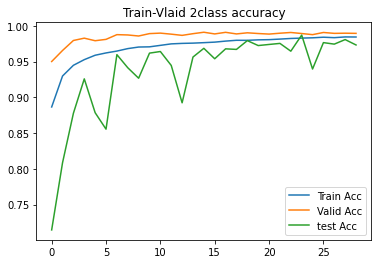

epoch 29 loss: 0.0414: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:02<00:00, 12.25it/s]


train 2class accuracy = 0.98500
[[32588   606]
 [  390 32804]]


epoch 29 loss: 0.0421: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.01it/s]


validation 2class accuracy = 0.98836
[[8248   38]
 [  66  580]]


epoch 29 loss: 0.2490: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.00it/s]


test 2class accuracy = 0.96167
[[47287  1846]
 [   47   212]]


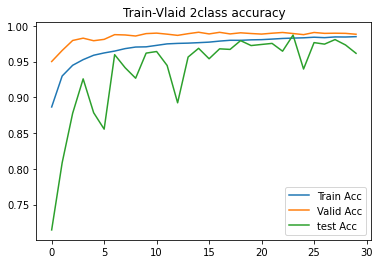

epoch 30 loss: 0.0445: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.06it/s]


train 2class accuracy = 0.98578
[[32616   578]
 [  366 32828]]


epoch 30 loss: 0.0404: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.50it/s]


validation 2class accuracy = 0.99026
[[8247   39]
 [  48  598]]


epoch 30 loss: 0.3021: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:52<00:00, 21.29it/s]


test 2class accuracy = 0.96180
[[47279  1854]
 [   33   226]]


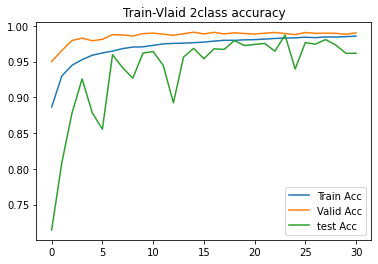

epoch 31 loss: 0.0452: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.04it/s]


train 2class accuracy = 0.98462
[[32589   605]
 [  416 32778]]


epoch 31 loss: 0.0516: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.25it/s]


validation 2class accuracy = 0.98970
[[8256   30]
 [  62  584]]


epoch 31 loss: 0.0978: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.52it/s]


test 2class accuracy = 0.97621
[[47989  1144]
 [   31   228]]


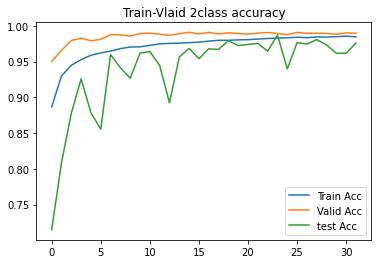

epoch 32 loss: 0.0462: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:14<00:00, 11.98it/s]


train 2class accuracy = 0.98583
[[32628   566]
 [  375 32819]]


epoch 32 loss: 0.0330: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.18it/s]


validation 2class accuracy = 0.98869
[[8256   30]
 [  71  575]]


epoch 32 loss: 0.0941: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.57it/s]


test 2class accuracy = 0.97368
[[47878  1255]
 [   45   214]]


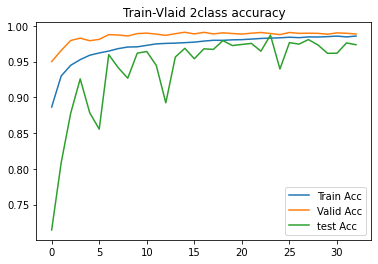

epoch 33 loss: 0.0360: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 12.00it/s]


train 2class accuracy = 0.98649
[[32644   550]
 [  347 32847]]


epoch 33 loss: 0.0384: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.41it/s]


validation 2class accuracy = 0.98791
[[8246   40]
 [  68  578]]


epoch 33 loss: 0.4751: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.43it/s]


test 2class accuracy = 0.96698
[[47533  1600]
 [   31   228]]


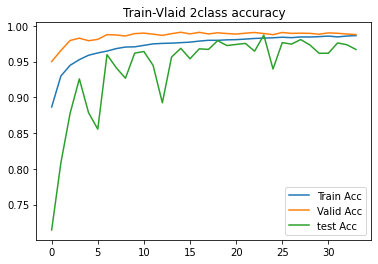

epoch 34 loss: 0.0347: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 11.98it/s]


train 2class accuracy = 0.98610
[[32629   565]
 [  358 32836]]


epoch 34 loss: 0.0366: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.02it/s]


validation 2class accuracy = 0.98757
[[8236   50]
 [  61  585]]


epoch 34 loss: 0.1032: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.75it/s]


test 2class accuracy = 0.96321
[[47353  1780]
 [   37   222]]


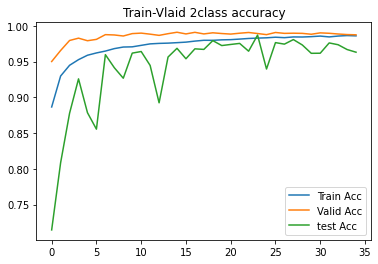

epoch 35 loss: 0.0323: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.98673
[[32666   528]
 [  353 32841]]


epoch 35 loss: 0.0459: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.87it/s]


validation 2class accuracy = 0.98836
[[8253   33]
 [  71  575]]


epoch 35 loss: 0.3337: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.91it/s]


test 2class accuracy = 0.96378
[[47385  1748]
 [   41   218]]


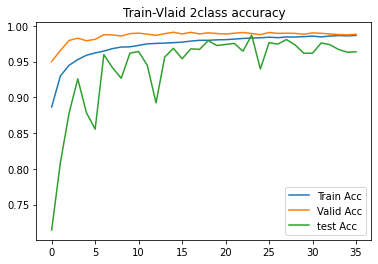

epoch 36 loss: 0.0348: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:01<00:00, 12.26it/s]


train 2class accuracy = 0.98652
[[32669   525]
 [  370 32824]]


epoch 36 loss: 0.0359: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.20it/s]


validation 2class accuracy = 0.98880
[[8257   29]
 [  71  575]]


epoch 36 loss: 0.0746: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.02it/s]


test 2class accuracy = 0.97884
[[48132  1001]
 [   44   215]]


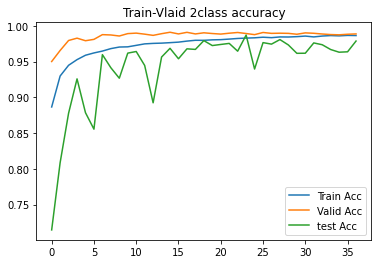

epoch 37 loss: 0.0242: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.29it/s]


train 2class accuracy = 0.98610
[[32635   559]
 [  364 32830]]


epoch 37 loss: 0.1063: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.13it/s]


validation 2class accuracy = 0.99149
[[8255   31]
 [  45  601]]


epoch 37 loss: 0.0742: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.73it/s]


test 2class accuracy = 0.97668
[[48014  1119]
 [   33   226]]


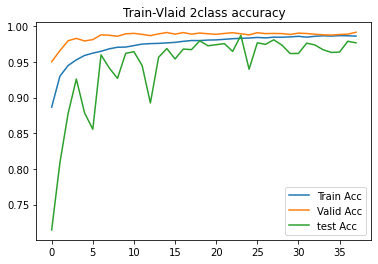

epoch 38 loss: 0.0285: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.31it/s]


train 2class accuracy = 0.98658
[[32655   539]
 [  352 32842]]


epoch 38 loss: 0.0308: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.95it/s]


validation 2class accuracy = 0.99015
[[8256   30]
 [  58  588]]


epoch 38 loss: 0.0811: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 21.99it/s]


test 2class accuracy = 0.97328
[[47852  1281]
 [   39   220]]


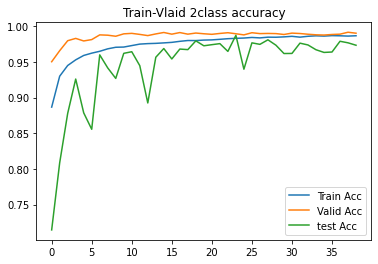

epoch 39 loss: 0.0374: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:06<00:00, 12.14it/s]


train 2class accuracy = 0.98765
[[32686   508]
 [  312 32882]]


epoch 39 loss: 0.0317: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.18it/s]


validation 2class accuracy = 0.99037
[[8265   21]
 [  65  581]]


epoch 39 loss: 0.0968: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.46it/s]


test 2class accuracy = 0.97988
[[48174   959]
 [   35   224]]


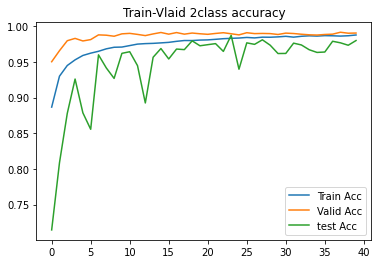

epoch 40 loss: 0.0291: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:14<00:00, 11.98it/s]


train 2class accuracy = 0.98715
[[32689   505]
 [  348 32846]]


epoch 40 loss: 0.0520: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.28it/s]


validation 2class accuracy = 0.99026
[[8258   28]
 [  59  587]]


epoch 40 loss: 0.1212: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.39it/s]


test 2class accuracy = 0.97060
[[47707  1426]
 [   26   233]]


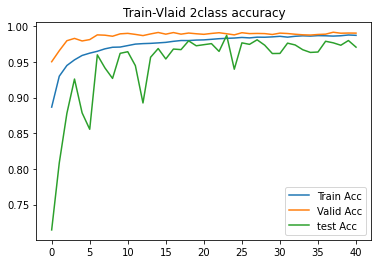

epoch 41 loss: 0.0362: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.05it/s]


train 2class accuracy = 0.98815
[[32711   483]
 [  304 32890]]


epoch 41 loss: 0.0314: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.67it/s]


validation 2class accuracy = 0.98936
[[8262   24]
 [  71  575]]


epoch 41 loss: 0.1183: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.74it/s]


test 2class accuracy = 0.97080
[[47719  1414]
 [   28   231]]


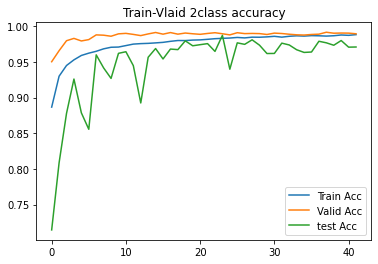

epoch 42 loss: 0.0340: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.05it/s]


train 2class accuracy = 0.98852
[[32728   466]
 [  296 32898]]


epoch 42 loss: 0.1058: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.83it/s]


validation 2class accuracy = 0.98970
[[8258   28]
 [  64  582]]


epoch 42 loss: 0.0909: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.69it/s]


test 2class accuracy = 0.97700
[[48028  1105]
 [   31   228]]


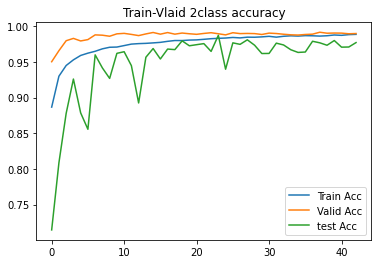

epoch 43 loss: 0.0356: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:12<00:00, 12.02it/s]


train 2class accuracy = 0.98801
[[32710   484]
 [  312 32882]]


epoch 43 loss: 0.0497: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.44it/s]


validation 2class accuracy = 0.99015
[[8267   19]
 [  69  577]]


epoch 43 loss: 0.1108: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.05it/s]


test 2class accuracy = 0.97844
[[48111  1022]
 [   43   216]]


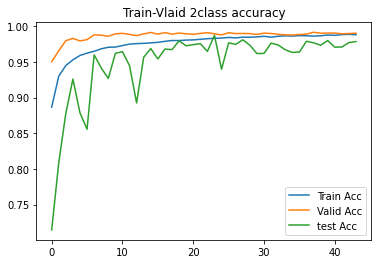

epoch 44 loss: 0.0449: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.28it/s]


train 2class accuracy = 0.98863
[[32737   457]
 [  298 32896]]


epoch 44 loss: 0.0336: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.16it/s]


validation 2class accuracy = 0.98992
[[8248   38]
 [  52  594]]


epoch 44 loss: 0.0802: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.11it/s]


test 2class accuracy = 0.97301
[[47831  1302]
 [   31   228]]


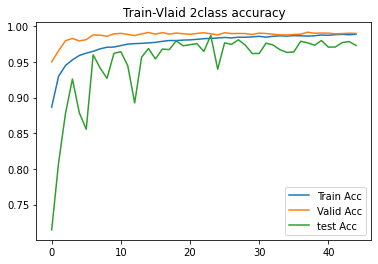

epoch 45 loss: 0.0236: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.98855
[[32735   459]
 [  301 32893]]


epoch 45 loss: 0.0319: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.08it/s]


validation 2class accuracy = 0.99138
[[8264   22]
 [  55  591]]


epoch 45 loss: 0.0619: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.11it/s]


test 2class accuracy = 0.98204
[[48291   842]
 [   45   214]]


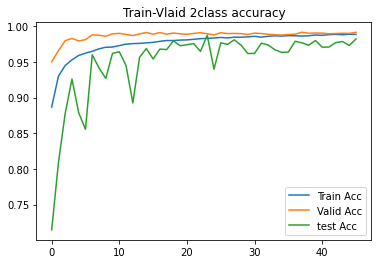

epoch 46 loss: 0.0274: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:58<00:00, 12.33it/s]


train 2class accuracy = 0.98822
[[32726   468]
 [  314 32880]]


epoch 46 loss: 0.0362: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.06it/s]


validation 2class accuracy = 0.99037
[[8263   23]
 [  63  583]]


epoch 46 loss: 0.0895: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.08it/s]


test 2class accuracy = 0.97390
[[47867  1266]
 [   23   236]]


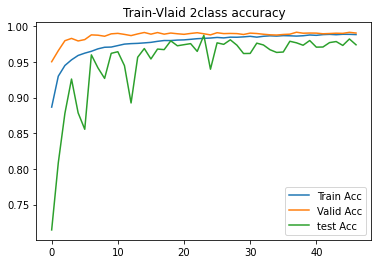

epoch 47 loss: 0.0230: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:57<00:00, 12.35it/s]


train 2class accuracy = 0.98903
[[32746   448]
 [  280 32914]]


epoch 47 loss: 0.0568: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.25it/s]


validation 2class accuracy = 0.99082
[[8254   32]
 [  50  596]]


epoch 47 loss: 0.0826: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.30it/s]


test 2class accuracy = 0.97137
[[47753  1380]
 [   34   225]]


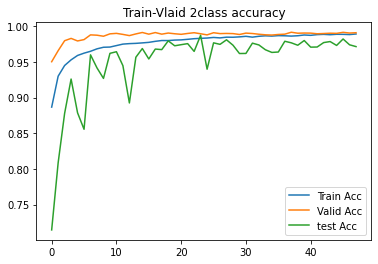

epoch 48 loss: 0.0317: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:06<00:00, 12.16it/s]


train 2class accuracy = 0.98834
[[32730   464]
 [  310 32884]]


epoch 48 loss: 0.0324: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.91it/s]


validation 2class accuracy = 0.99015
[[8264   22]
 [  66  580]]


epoch 48 loss: 0.0830: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.70it/s]


test 2class accuracy = 0.97680
[[48049  1084]
 [   62   197]]


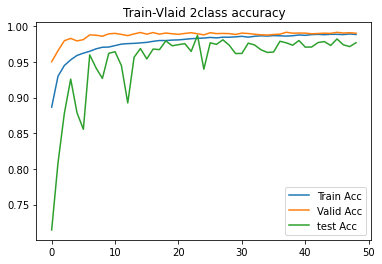

epoch 49 loss: 0.0391: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 11.99it/s]


train 2class accuracy = 0.98881
[[32746   448]
 [  295 32899]]


epoch 49 loss: 0.1441: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.54it/s]


validation 2class accuracy = 0.99082
[[8260   26]
 [  56  590]]


epoch 49 loss: 0.0732: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:48<00:00, 21.65it/s]


test 2class accuracy = 0.97508
[[47942  1191]
 [   40   219]]


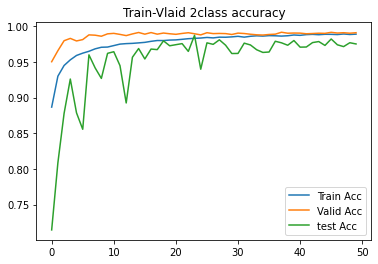

epoch 50 loss: 0.0296: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.06it/s]


train 2class accuracy = 0.98920
[[32767   427]
 [  290 32904]]


epoch 50 loss: 0.1062: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.43it/s]


validation 2class accuracy = 0.99093
[[8258   28]
 [  53  593]]


epoch 50 loss: 0.1022: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.82it/s]


test 2class accuracy = 0.96720
[[47537  1596]
 [   24   235]]


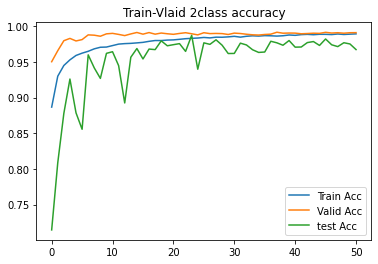

epoch 51 loss: 0.0365: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.03it/s]


train 2class accuracy = 0.98912
[[32744   450]
 [  272 32922]]


epoch 51 loss: 0.0803: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.46it/s]


validation 2class accuracy = 0.99048
[[8260   26]
 [  59  587]]


epoch 51 loss: 0.1153: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.49it/s]


test 2class accuracy = 0.96165
[[47286  1847]
 [   47   212]]


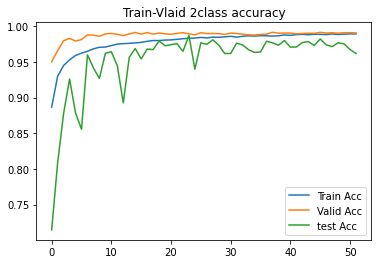

epoch 52 loss: 0.0318: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.06it/s]


train 2class accuracy = 0.98894
[[32752   442]
 [  292 32902]]


epoch 52 loss: 0.0432: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.60it/s]


validation 2class accuracy = 0.99060
[[8258   28]
 [  56  590]]


epoch 52 loss: 0.0817: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.07it/s]


test 2class accuracy = 0.97489
[[47941  1192]
 [   48   211]]


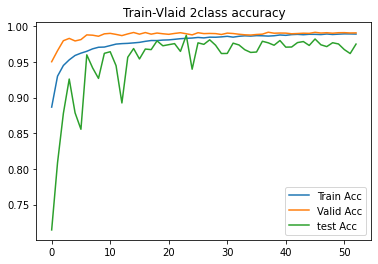

epoch 53 loss: 0.0300: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.30it/s]


train 2class accuracy = 0.98971
[[32788   406]
 [  277 32917]]


epoch 53 loss: 0.3305: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.22it/s]


validation 2class accuracy = 0.98880
[[8271   15]
 [  85  561]]


epoch 53 loss: 0.1388: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.19it/s]


test 2class accuracy = 0.97848
[[48120  1013]
 [   50   209]]


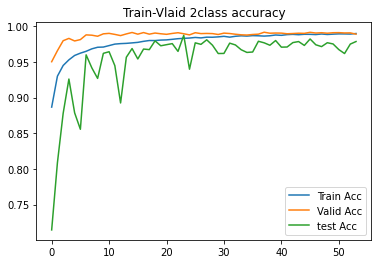

epoch 54 loss: 0.0223: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:08<00:00, 12.10it/s]


train 2class accuracy = 0.98979
[[32788   406]
 [  272 32922]]


epoch 54 loss: 0.0462: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.14it/s]


validation 2class accuracy = 0.99116
[[8263   23]
 [  56  590]]


epoch 54 loss: 0.0734: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 21.99it/s]


test 2class accuracy = 0.97293
[[47827  1306]
 [   31   228]]


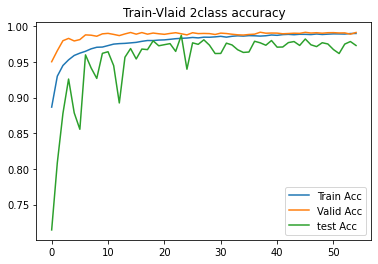

epoch 55 loss: 0.0209: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.29it/s]


train 2class accuracy = 0.99013
[[32794   400]
 [  255 32939]]


epoch 55 loss: 0.0643: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.98it/s]


validation 2class accuracy = 0.99015
[[8270   16]
 [  72  574]]


epoch 55 loss: 0.0562: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.08it/s]


test 2class accuracy = 0.98077
[[48235   898]
 [   52   207]]


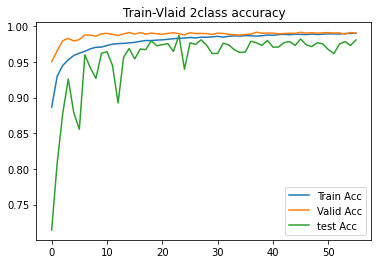

epoch 56 loss: 0.0295: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.28it/s]


train 2class accuracy = 0.99033
[[32791   403]
 [  239 32955]]


epoch 56 loss: 0.3471: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.95it/s]


validation 2class accuracy = 0.98970
[[8256   30]
 [  62  584]]


epoch 56 loss: 0.1327: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.00it/s]


test 2class accuracy = 0.96728
[[47562  1571]
 [   45   214]]


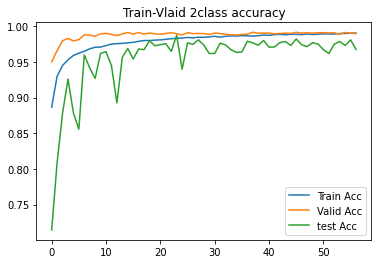

epoch 57 loss: 0.0371: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:07<00:00, 12.12it/s]


train 2class accuracy = 0.98956
[[32782   412]
 [  281 32913]]


epoch 57 loss: 0.1597: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.17it/s]


validation 2class accuracy = 0.99037
[[8255   31]
 [  55  591]]


epoch 57 loss: 0.1335: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:48<00:00, 21.58it/s]


test 2class accuracy = 0.95173
[[46775  2358]
 [   26   233]]


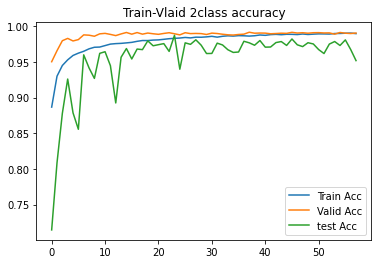

epoch 58 loss: 0.0264: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:12<00:00, 12.01it/s]


train 2class accuracy = 0.99059
[[32819   375]
 [  250 32944]]


epoch 58 loss: 0.1812: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.28it/s]


validation 2class accuracy = 0.98948
[[8267   19]
 [  75  571]]


epoch 58 loss: 0.1182: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.48it/s]


test 2class accuracy = 0.96728
[[47544  1589]
 [   27   232]]


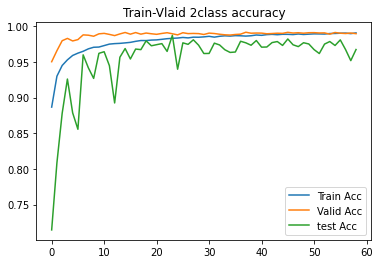

epoch 59 loss: 0.0229: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:12<00:00, 12.01it/s]


train 2class accuracy = 0.99012
[[32788   406]
 [  250 32944]]


epoch 59 loss: 0.3980: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.50it/s]


validation 2class accuracy = 0.99037
[[8268   18]
 [  68  578]]


epoch 59 loss: 0.0797: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:48<00:00, 21.59it/s]


test 2class accuracy = 0.97481
[[47930  1203]
 [   41   218]]


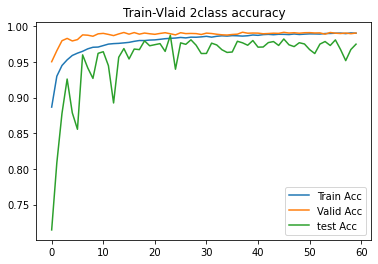

epoch 60 loss: 0.0290: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:14<00:00, 11.97it/s]


train 2class accuracy = 0.98976
[[32785   409]
 [  271 32923]]


epoch 60 loss: 0.2977: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.35it/s]


validation 2class accuracy = 0.99037
[[8275   11]
 [  75  571]]


epoch 60 loss: 0.0804: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.50it/s]


test 2class accuracy = 0.97734
[[48058  1075]
 [   44   215]]


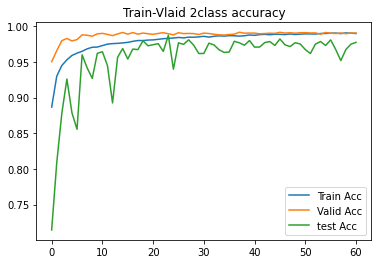

epoch 61 loss: 0.0216: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:14<00:00, 11.97it/s]


train 2class accuracy = 0.99111
[[32827   367]
 [  223 32971]]


epoch 61 loss: 0.0674: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.84it/s]


validation 2class accuracy = 0.99037
[[8269   17]
 [  69  577]]


epoch 61 loss: 0.1190: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.06it/s]


test 2class accuracy = 0.96129
[[47255  1878]
 [   34   225]]


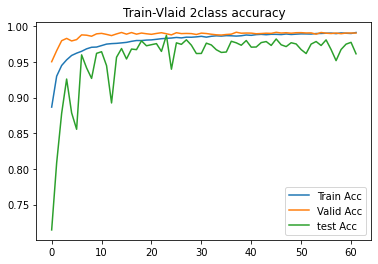

epoch 62 loss: 0.0283: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:02<00:00, 12.25it/s]


train 2class accuracy = 0.99063
[[32816   378]
 [  244 32950]]


epoch 62 loss: 0.0509: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.55it/s]


validation 2class accuracy = 0.98959
[[8271   15]
 [  78  568]]


epoch 62 loss: 0.0873: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.95it/s]


test 2class accuracy = 0.97799
[[48096  1037]
 [   50   209]]


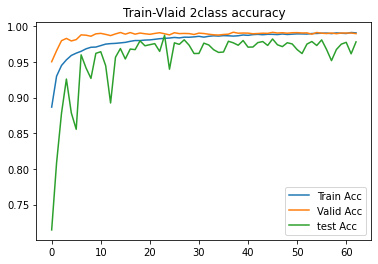

epoch 63 loss: 0.0288: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:01<00:00, 12.25it/s]


train 2class accuracy = 0.99027
[[32812   382]
 [  264 32930]]


epoch 63 loss: 0.0765: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.14it/s]


validation 2class accuracy = 0.99071
[[8264   22]
 [  61  585]]


epoch 63 loss: 0.1597: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.01it/s]


test 2class accuracy = 0.95627
[[46997  2136]
 [   24   235]]


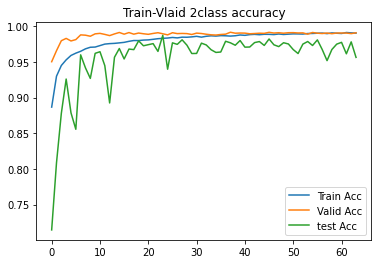

epoch 64 loss: 0.0263: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.29it/s]


train 2class accuracy = 0.99159
[[32852   342]
 [  216 32978]]


epoch 64 loss: 0.0559: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.27it/s]


validation 2class accuracy = 0.99127
[[8273   13]
 [  65  581]]


epoch 64 loss: 0.0499: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:45<00:00, 21.90it/s]


test 2class accuracy = 0.98372
[[48373   760]
 [   44   215]]


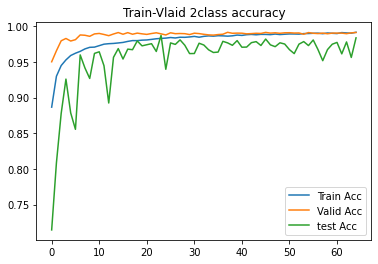

epoch 65 loss: 0.0199: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:02<00:00, 12.23it/s]


train 2class accuracy = 0.99080
[[32825   369]
 [  242 32952]]


epoch 65 loss: 0.8516: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.84it/s]


validation 2class accuracy = 0.99082
[[8264   22]
 [  60  586]]


epoch 65 loss: 0.0734: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.17it/s]


test 2class accuracy = 0.97524
[[47948  1185]
 [   38   221]]


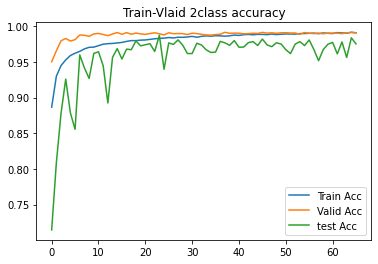

epoch 66 loss: 0.0270: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:06<00:00, 12.16it/s]


train 2class accuracy = 0.99092
[[32831   363]
 [  240 32954]]


epoch 66 loss: 0.0468: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.74it/s]


validation 2class accuracy = 0.99127
[[8273   13]
 [  65  581]]


epoch 66 loss: 0.0518: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.71it/s]


test 2class accuracy = 0.98346
[[48345   788]
 [   29   230]]


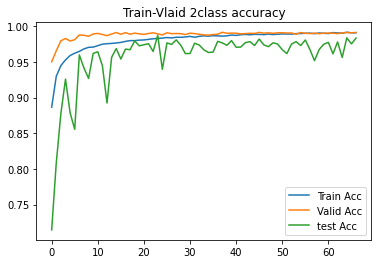

epoch 67 loss: 0.0223: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:10<00:00, 12.05it/s]


train 2class accuracy = 0.99114
[[32845   349]
 [  239 32955]]


epoch 67 loss: 0.2403: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.27it/s]


validation 2class accuracy = 0.98869
[[8259   27]
 [  74  572]]


epoch 67 loss: 0.1085: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.67it/s]


test 2class accuracy = 0.96530
[[47463  1670]
 [   44   215]]


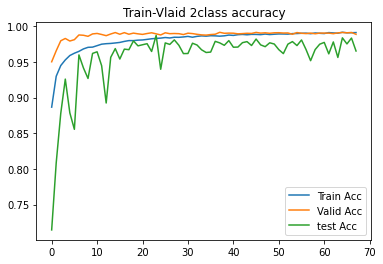

epoch 68 loss: 0.0219: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:12<00:00, 12.02it/s]


train 2class accuracy = 0.99128
[[32849   345]
 [  234 32960]]


epoch 68 loss: 0.1297: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.51it/s]


validation 2class accuracy = 0.98970
[[8265   21]
 [  71  575]]


epoch 68 loss: 0.0911: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:47<00:00, 21.74it/s]


test 2class accuracy = 0.96985
[[47694  1439]
 [   50   209]]


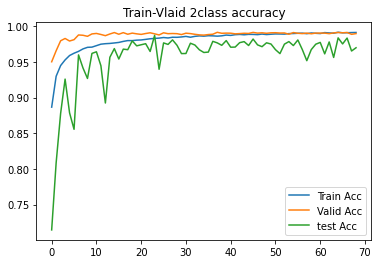

epoch 69 loss: 0.0262: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:09<00:00, 12.08it/s]


train 2class accuracy = 0.99117
[[32823   371]
 [  215 32979]]


epoch 69 loss: 0.7006: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.54it/s]


validation 2class accuracy = 0.98925
[[8265   21]
 [  75  571]]


epoch 69 loss: 0.2189: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.79it/s]


test 2class accuracy = 0.95975
[[47203  1930]
 [   58   201]]


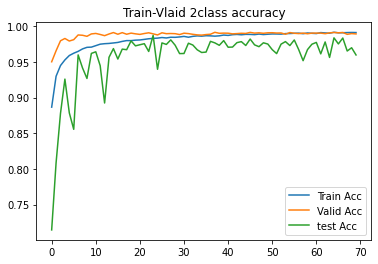

epoch 70 loss: 0.0246: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:11<00:00, 12.05it/s]


train 2class accuracy = 0.99146
[[32839   355]
 [  212 32982]]


epoch 70 loss: 0.1788: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.64it/s]


validation 2class accuracy = 0.99093
[[8270   16]
 [  65  581]]


epoch 70 loss: 0.0823: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.03it/s]


test 2class accuracy = 0.98075
[[48229   904]
 [   47   212]]


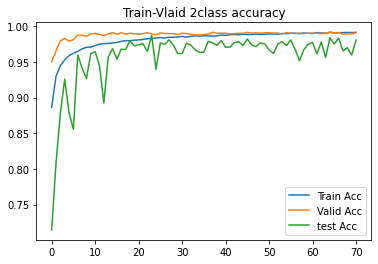

epoch 71 loss: 0.0305: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:58<00:00, 12.34it/s]


train 2class accuracy = 0.99140
[[32843   351]
 [  220 32974]]


epoch 71 loss: 0.2168: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.18it/s]


validation 2class accuracy = 0.98824
[[8268   18]
 [  87  559]]


epoch 71 loss: 0.1724: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.19it/s]


test 2class accuracy = 0.97494
[[47942  1191]
 [   47   212]]


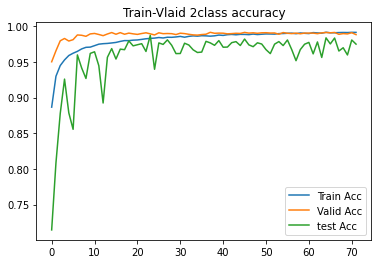

epoch 72 loss: 0.0236: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:01<00:00, 12.26it/s]


train 2class accuracy = 0.99149
[[32858   336]
 [  229 32965]]


epoch 72 loss: 0.1329: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.10it/s]


validation 2class accuracy = 0.98847
[[8265   21]
 [  82  564]]


epoch 72 loss: 0.2403: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.00it/s]


test 2class accuracy = 0.96771
[[47575  1558]
 [   37   222]]


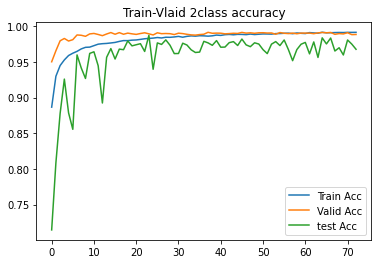

epoch 73 loss: 0.0221: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.31it/s]


train 2class accuracy = 0.99191
[[32870   324]
 [  213 32981]]


epoch 73 loss: 0.1766: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.00it/s]


validation 2class accuracy = 0.99160
[[8272   14]
 [  61  585]]


epoch 73 loss: 0.0505: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:46<00:00, 21.77it/s]


test 2class accuracy = 0.98188
[[48283   850]
 [   45   214]]


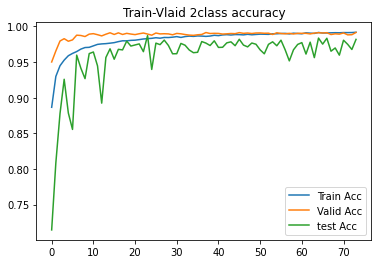

epoch 74 loss: 0.0158: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:59<00:00, 12.31it/s]


train 2class accuracy = 0.99128
[[32837   357]
 [  222 32972]]


epoch 74 loss: 0.0741: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.85it/s]


validation 2class accuracy = 0.99205
[[8275   11]
 [  60  586]]


epoch 74 loss: 0.0440: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.03it/s]


test 2class accuracy = 0.98558
[[48470   663]
 [   49   210]]


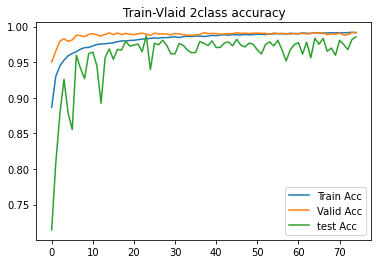

epoch 75 loss: 0.0150: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:07<00:00, 12.13it/s]


train 2class accuracy = 0.99132
[[32838   356]
 [  220 32974]]


epoch 75 loss: 0.5577: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.37it/s]


validation 2class accuracy = 0.98981
[[8263   23]
 [  68  578]]


epoch 75 loss: 0.1295: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:48<00:00, 21.58it/s]


test 2class accuracy = 0.97119
[[47745  1388]
 [   35   224]]


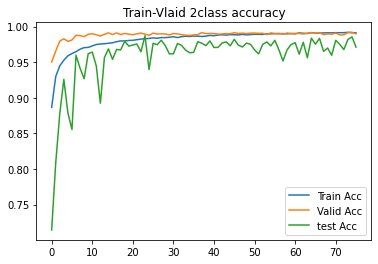

epoch 76 loss: 0.0233: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 12.00it/s]


train 2class accuracy = 0.99164
[[32859   335]
 [  220 32974]]


epoch 76 loss: 0.0671: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.30it/s]


validation 2class accuracy = 0.98925
[[8275   11]
 [  85  561]]


epoch 76 loss: 0.1106: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:49<00:00, 21.48it/s]


test 2class accuracy = 0.98093
[[48243   890]
 [   52   207]]


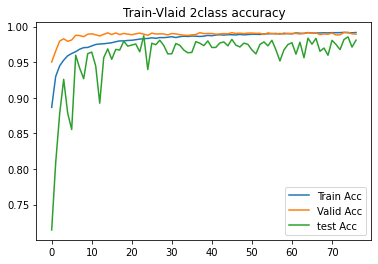

epoch 77 loss: 0.0247: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:12<00:00, 12.02it/s]


train 2class accuracy = 0.99226
[[32884   310]
 [  204 32990]]


epoch 77 loss: 0.5838: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.72it/s]


validation 2class accuracy = 0.99037
[[8272   14]
 [  72  574]]


epoch 77 loss: 0.1444: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:48<00:00, 21.60it/s]


test 2class accuracy = 0.97613
[[47991  1142]
 [   37   222]]


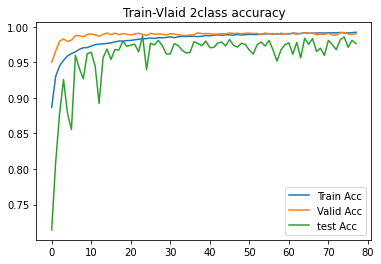

epoch 78 loss: 0.0258: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:13<00:00, 11.99it/s]


train 2class accuracy = 0.99194
[[32866   328]
 [  207 32987]]


epoch 78 loss: 0.4294: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.42it/s]


validation 2class accuracy = 0.99104
[[8273   13]
 [  67  579]]


epoch 78 loss: 0.0539: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:50<00:00, 21.43it/s]


test 2class accuracy = 0.98194
[[48285   848]
 [   44   215]]


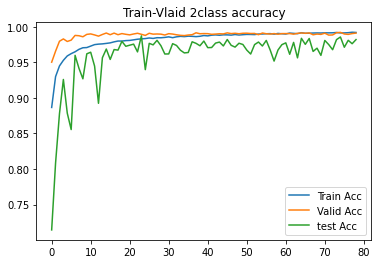

epoch 79 loss: 0.0197: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:12<00:00, 12.02it/s]


train 2class accuracy = 0.99227
[[32883   311]
 [  202 32992]]


epoch 79 loss: 0.0489: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.85it/s]


validation 2class accuracy = 0.98992
[[8266   20]
 [  70  576]]


epoch 79 loss: 0.0882: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.18it/s]


test 2class accuracy = 0.97374
[[47861  1272]
 [   25   234]]


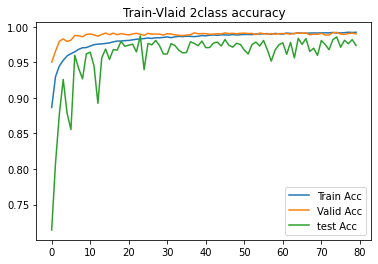

epoch 80 loss: 0.0307: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:00<00:00, 12.27it/s]


train 2class accuracy = 0.99223
[[32888   306]
 [  210 32984]]


epoch 80 loss: 0.0797: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.80it/s]


validation 2class accuracy = 0.99116
[[8271   15]
 [  64  582]]


epoch 80 loss: 0.0571: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.10it/s]


test 2class accuracy = 0.98265
[[48308   825]
 [   32   227]]


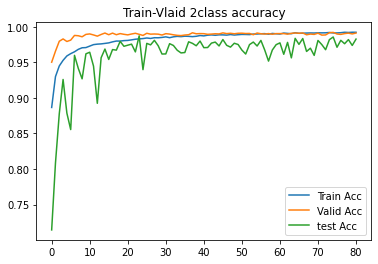

epoch 81 loss: 0.0132: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:01<00:00, 12.27it/s]


train 2class accuracy = 0.99232
[[32875   319]
 [  191 33003]]


epoch 81 loss: 0.0452: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.00it/s]


validation 2class accuracy = 0.99026
[[8265   21]
 [  66  580]]


epoch 81 loss: 0.1269: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:30<00:00, 23.42it/s]


test 2class accuracy = 0.96105
[[47237  1896]
 [   28   231]]


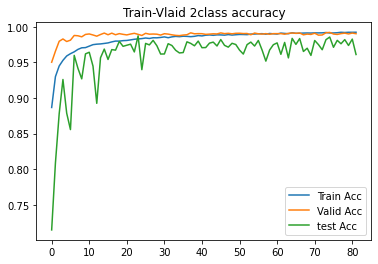

epoch 82 loss: 0.0231: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:53<00:00, 12.43it/s]


train 2class accuracy = 0.99206
[[32879   315]
 [  212 32982]]


epoch 82 loss: 0.0772: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.64it/s]


validation 2class accuracy = 0.98892
[[8268   18]
 [  81  565]]


epoch 82 loss: 0.1394: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.35it/s]


test 2class accuracy = 0.97708
[[48039  1094]
 [   38   221]]


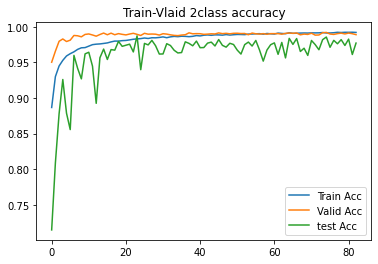

epoch 83 loss: 0.0222: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:54<00:00, 12.42it/s]


train 2class accuracy = 0.99218
[[32881   313]
 [  206 32988]]


epoch 83 loss: 0.0640: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.69it/s]


validation 2class accuracy = 0.99048
[[8273   13]
 [  72  574]]


epoch 83 loss: 0.2102: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:37<00:00, 22.75it/s]


test 2class accuracy = 0.97366
[[47858  1275]
 [   26   233]]


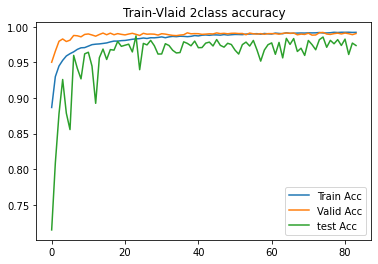

epoch 84 loss: 0.0266: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:52<00:00, 12.46it/s]


train 2class accuracy = 0.99245
[[32893   301]
 [  200 32994]]


epoch 84 loss: 0.1245: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.18it/s]


validation 2class accuracy = 0.98880
[[8272   14]
 [  86  560]]


epoch 84 loss: 0.0548: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:40<00:00, 22.42it/s]


test 2class accuracy = 0.98449
[[48408   725]
 [   41   218]]


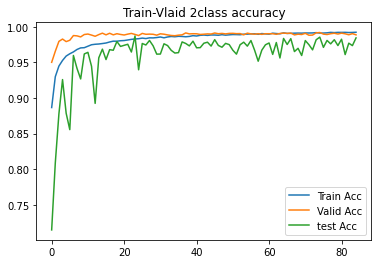

epoch 85 loss: 0.0231: 100%|███████████████████████████████████████████████████████| 6639/6639 [09:01<00:00, 12.26it/s]


train 2class accuracy = 0.99266
[[32913   281]
 [  206 32988]]


epoch 85 loss: 0.0328: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.40it/s]


validation 2class accuracy = 0.99116
[[8269   17]
 [  62  584]]


epoch 85 loss: 0.2614: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:34<00:00, 23.01it/s]


test 2class accuracy = 0.97585
[[47973  1160]
 [   33   226]]


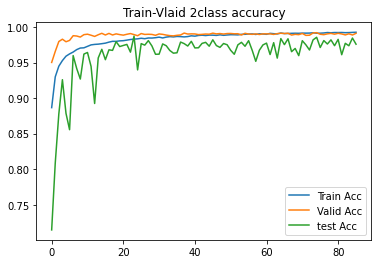

epoch 86 loss: 0.0197: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:52<00:00, 12.46it/s]


train 2class accuracy = 0.99295
[[32899   295]
 [  173 33021]]


epoch 86 loss: 0.0387: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.15it/s]


validation 2class accuracy = 0.99048
[[8277    9]
 [  76  570]]


epoch 86 loss: 0.0546: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.19it/s]


test 2class accuracy = 0.98399
[[48373   760]
 [   31   228]]


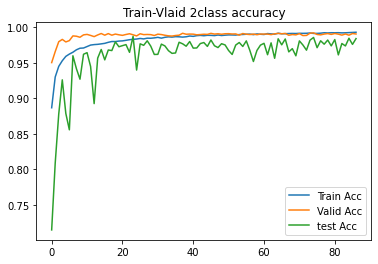

epoch 87 loss: 0.0327: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:51<00:00, 12.48it/s]


train 2class accuracy = 0.99259
[[32896   298]
 [  194 33000]]


epoch 87 loss: 0.0371: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.11it/s]


validation 2class accuracy = 0.99026
[[8271   15]
 [  72  574]]


epoch 87 loss: 0.0654: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:40<00:00, 22.43it/s]


test 2class accuracy = 0.97994
[[48167   966]
 [   25   234]]


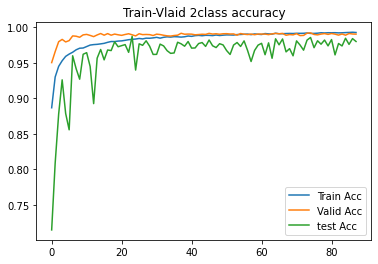

epoch 88 loss: 0.0132: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:53<00:00, 12.45it/s]


train 2class accuracy = 0.99292
[[32909   285]
 [  185 33009]]


epoch 88 loss: 0.2500: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.13it/s]


validation 2class accuracy = 0.99037
[[8271   15]
 [  71  575]]


epoch 88 loss: 0.0763: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:38<00:00, 22.64it/s]


test 2class accuracy = 0.98220
[[48287   846]
 [   33   226]]


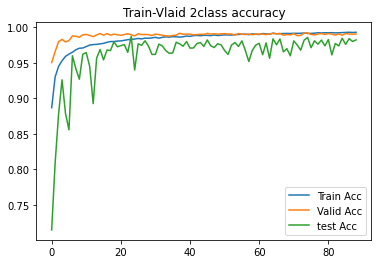

epoch 89 loss: 0.0191: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:56<00:00, 12.37it/s]


train 2class accuracy = 0.99275
[[32910   284]
 [  197 32997]]


epoch 89 loss: 0.2351: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.47it/s]


validation 2class accuracy = 0.98981
[[8272   14]
 [  77  569]]


epoch 89 loss: 0.0631: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.29it/s]


test 2class accuracy = 0.98200
[[48278   855]
 [   34   225]]


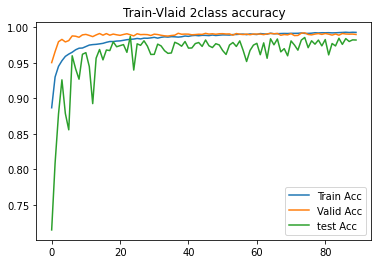

epoch 90 loss: 0.0235: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:56<00:00, 12.38it/s]


train 2class accuracy = 0.99238
[[32885   309]
 [  197 32997]]


epoch 90 loss: 0.0592: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.23it/s]


validation 2class accuracy = 0.98892
[[8277    9]
 [  90  556]]


epoch 90 loss: 0.0744: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:38<00:00, 22.66it/s]


test 2class accuracy = 0.97538
[[47948  1185]
 [   31   228]]


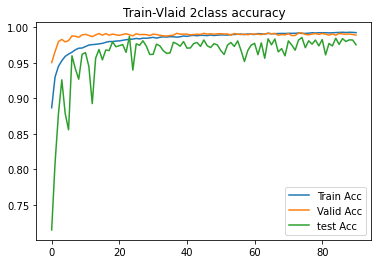

epoch 91 loss: 0.0176: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:50<00:00, 12.51it/s]


train 2class accuracy = 0.99263
[[32897   297]
 [  192 33002]]


epoch 91 loss: 0.0511: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.62it/s]


validation 2class accuracy = 0.99116
[[8272   14]
 [  65  581]]


epoch 91 loss: 0.0875: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:38<00:00, 22.56it/s]


test 2class accuracy = 0.97244
[[47799  1334]
 [   27   232]]


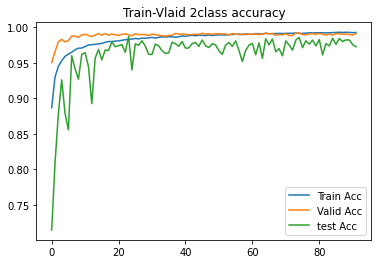

epoch 92 loss: 0.0283: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:56<00:00, 12.37it/s]


train 2class accuracy = 0.99316
[[32914   280]
 [  174 33020]]


epoch 92 loss: 0.0424: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.77it/s]


validation 2class accuracy = 0.99026
[[8279    7]
 [  80  566]]


epoch 92 loss: 0.0416: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:38<00:00, 22.56it/s]


test 2class accuracy = 0.98775
[[48579   554]
 [   51   208]]


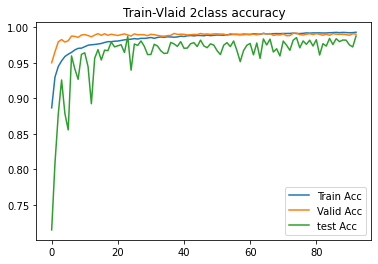

epoch 93 loss: 0.0166: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:48<00:00, 12.56it/s]


train 2class accuracy = 0.99312
[[32919   275]
 [  182 33012]]


epoch 93 loss: 0.0479: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.99it/s]


validation 2class accuracy = 0.98936
[[8266   20]
 [  75  571]]


epoch 93 loss: 0.0726: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.11it/s]


test 2class accuracy = 0.97797
[[48086  1047]
 [   41   218]]


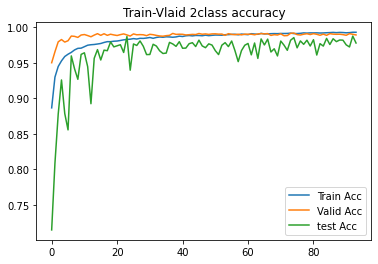

epoch 94 loss: 0.0205: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:50<00:00, 12.51it/s]


train 2class accuracy = 0.99316
[[32935   259]
 [  195 32999]]


epoch 94 loss: 0.7552: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.01it/s]


validation 2class accuracy = 0.98959
[[8267   19]
 [  74  572]]


epoch 94 loss: 0.1369: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:44<00:00, 22.05it/s]


test 2class accuracy = 0.97080
[[47742  1391]
 [   51   208]]


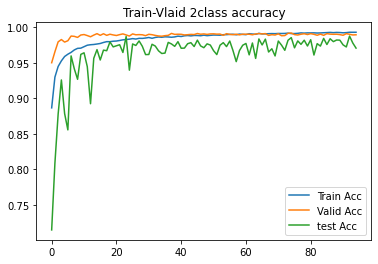

epoch 95 loss: 0.0231: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:47<00:00, 12.58it/s]


train 2class accuracy = 0.99321
[[32917   277]
 [  174 33020]]


epoch 95 loss: 0.0481: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.97it/s]


validation 2class accuracy = 0.99060
[[8277    9]
 [  75  571]]


epoch 95 loss: 0.0656: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.22it/s]


test 2class accuracy = 0.98435
[[48404   729]
 [   44   215]]


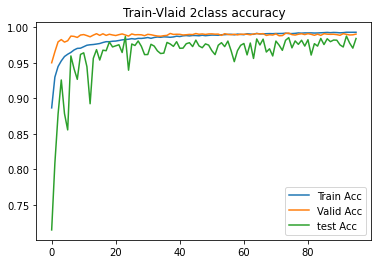

epoch 96 loss: 0.0179: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:48<00:00, 12.57it/s]


train 2class accuracy = 0.99260
[[32895   299]
 [  192 33002]]


epoch 96 loss: 0.0340: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.01it/s]


validation 2class accuracy = 0.99015
[[8269   17]
 [  71  575]]


epoch 96 loss: 0.0811: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:43<00:00, 22.14it/s]


test 2class accuracy = 0.97564
[[47965  1168]
 [   35   224]]


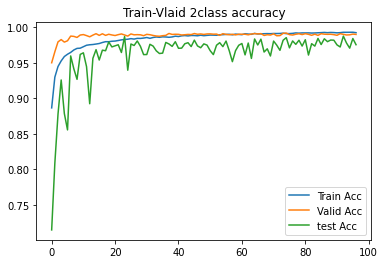

epoch 97 loss: 0.0203: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:49<00:00, 12.53it/s]


train 2class accuracy = 0.99250
[[32904   290]
 [  208 32986]]


epoch 97 loss: 0.0364: 100%|█████████████████████████████████████████████████████████| 894/894 [00:29<00:00, 30.64it/s]


validation 2class accuracy = 0.99104
[[8270   16]
 [  64  582]]


epoch 97 loss: 0.0825: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:42<00:00, 22.23it/s]


test 2class accuracy = 0.97595
[[47974  1159]
 [   29   230]]


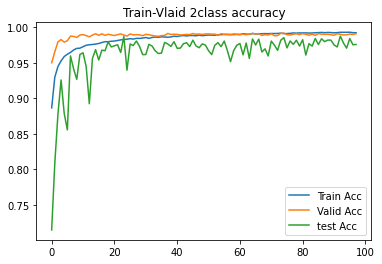

epoch 98 loss: 0.0176: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:55<00:00, 12.40it/s]


train 2class accuracy = 0.99303
[[32917   277]
 [  186 33008]]


epoch 98 loss: 0.3014: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 31.58it/s]


validation 2class accuracy = 0.99060
[[8262   24]
 [  60  586]]


epoch 98 loss: 0.1582: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.33it/s]


test 2class accuracy = 0.95129
[[46752  2381]
 [   25   234]]


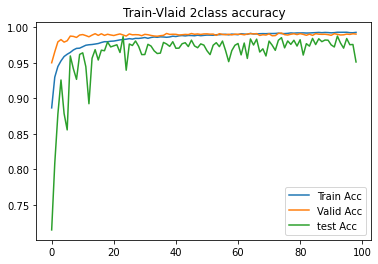

epoch 99 loss: 0.0267: 100%|███████████████████████████████████████████████████████| 6639/6639 [08:46<00:00, 12.62it/s]


train 2class accuracy = 0.99309
[[32926   268]
 [  191 33003]]


epoch 99 loss: 0.0421: 100%|█████████████████████████████████████████████████████████| 894/894 [00:28<00:00, 30.86it/s]


validation 2class accuracy = 0.99026
[[8271   15]
 [  72  574]]


epoch 99 loss: 0.0792: 100%|███████████████████████████████████████████████████████| 4940/4940 [03:41<00:00, 22.27it/s]


test 2class accuracy = 0.97429
[[47896  1237]
 [   33   226]]


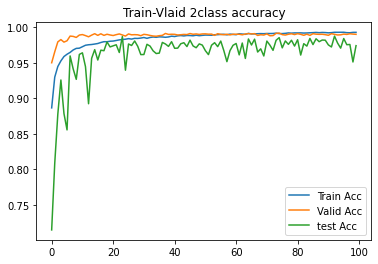

time : 22:38:13
Best Epoch : 74
Best Train Accuracy : 0.99128
[[32837   357]
 [  222 32972]]
Best Valid Accuracy : 0.99205
[[8275   11]
 [  60  586]]


In [30]:
model_dir = '../models/221211/{}'.format(CFG['model_arch'])
trn_root='D:/polyps'
val_root='D:/polyps'
tst_root='D:/@image_data/open_data/@sun_data/'


wandb.init(project="stool_classfication", entity="kyungbin")
wandb.run.name = 'stool_classfication_124'

# Optional"
wandb.watch(model)


if __name__ == '__main__':
     # for training only, need nightly build pytorch
    
    seed_everything(CFG['seed'])
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
    
        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader, tst_loader = prepare_dataloader(train,valid,test ,trn_idx, val_idx, trn_root,val_root,tst_root)

        device = torch.device(CFG['device'])
        
        model = ColonImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)

        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], 
                                     #weight_decay=CFG['weight_decay']
                                    )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=25)
#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        #scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps=5, base_lr=0.3, final_lr=0.01)
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        loss_fn1 = nn.CrossEntropyLoss().to(device)
        
        train_acc_list = []
        train_matrix_list = []
        valid_acc_list = []
        valid_matrix_list = []
        test_acc_list = []
        test_matrix_list = []
        
        
        
        start = time.time()
        for epoch in range(CFG['epochs']):
            
            train_preds_all, train_acc, train_matrix,train_loss = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, 
                                                                       scheduler=None, schd_batch_update=False)
            
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_matrix,valid_loss= valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)
                test_preds_all, test_acc, test_matrix,test_loss= test_one_epoch(epoch, model, loss_fn1, tst_loader, device, scheduler=None, schd_loss_update=False)

                
            torch.save(model.state_dict(), (model_dir+'/stool_classfication_124_{}_fold_{}_{}').format(CFG['model_arch'], fold, epoch))
            
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            test_acc_list.append(test_acc)
            test_matrix_list.append(test_matrix)
        
            plt.plot(train_acc_list, label='Train Acc')
            plt.plot(valid_acc_list, label='Valid Acc')
            plt.plot(test_acc_list, label='test Acc')
            plt.title('Train-Vlaid 2class accuracy')
            plt.legend()
            plt.show()
            
            
            wandb.log({"valid_loss": valid_loss,
                       "valid_accuracy":valid_acc,
                       "test_loss": test_loss,
                       #"valid_recall": valid_recall,
          "train_loss": train_loss,
          "train Acc": train_acc,
          "test acc ": test_acc
          })
            
            
            
            
        
        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)
            
        best_index = valid_acc_list.index(max(valid_acc_list))
        print(f'Best Epoch : {best_index}')
        print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        
        del model, optimizer, train_loader, val_loader,tst_loader, scaler
        torch.cuda.empty_cache()
        
        # we'll train fold 0 first
        if fold == 0:
            break 

    train_preds_all = train_preds_all
    valid_preds_all = valid_preds_all
    test_preds_all = test_preds_all